In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

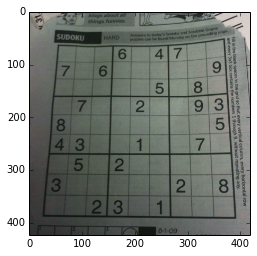

In [149]:
img_org = cv2.imread("./examples/s5.png")
img = cv2.cvtColor(img_org, cv2.COLOR_BGR2GRAY)
plt.imshow(img_org)

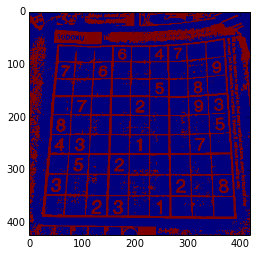

In [150]:
w = img.shape[0]/10
if w % 2 == 0:
    w += 1

th = cv2.adaptiveThreshold(
    img,
    maxValue=1,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=w,
    C=0,
)
plt.imshow(th)

21


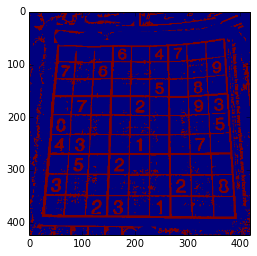

In [151]:
w2 = (w/2)
if w2 % 2 == 0:
    w2 += 1
print w2
th2 = cv2.adaptiveThreshold(
    th,
    maxValue=1,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C,
    thresholdType=cv2.THRESH_BINARY,
    blockSize=w2,
    C=0,
)
plt.imshow(th2)

In [152]:
# th3 = cv2.medianBlur(th2, ksize=3)
# plt.imshow(th3)

In [153]:
def draw_hlines(img, lines):
    cpy = img.copy()
    
    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(cpy,(x1,y1),(x2,y2),(0,0,255),2)
    
    return cpy

def similar_angle(line_a, line_b, min_ang_diff=0.5):
    """
    lines has to differ by some value
    otherwise intersection is not interesting
    """
    if min_ang_diff <= 0:
        return False
    
    th_a = line_a[0][1]
    th_b = line_b[0][1]
    
    ang_diff = np.abs(th_a - th_b)
    if ang_diff < min_ang_diff or ang_diff > (np.pi - min_ang_diff):
        return True
    return False

def intersection(line_a, line_b, min_ang_diff=0):
    """
    Solve:
    x*cos(th_a) + y*sin(th_a) = r_a
    x*cos(th_b) + y*sin(th_b) = r_b
    
    As matrix:
    A*X = b
    """
    r_a, th_a = line_a[0]
    r_b, th_b = line_b[0]

#     if min_ang_diff and similar_angle(line_a, line_b, min_ang_diff):
#         return None, (0, 0)
    
    A = np.array([
        [np.cos(th_a), np.sin(th_a)],
        [np.cos(th_b), np.sin(th_b)],
    ])
    b = np.array([r_a, r_b])
    ret, dst = cv2.solve(A, b)
    return ret, dst

def point_in_view(point, img_shape, scope=0.5):
    """
    scope: padding to size. 0.5 = 50%
    """
    w, h = img_shape
    x, y = point
    
    min_x = 0 - w*scope
    min_y = 0 - h*scope
    max_x = w + w*scope
    max_y = h + h*scope
    
    return (
        min_x <= x <= max_x and
        min_y <= y <= max_y
    )

def remove_duplicate_lines(lines, min_ang_diff, img_shape):
    """
    duplicates: crosses in view at low angle 
    """
    to_remove = set([])
    for i, line_a in enumerate(lines):
        for j, line_b in enumerate(lines):
            if i <= j:
                continue
            
            ok, point = intersection(line_a, line_b)
            if not ok:
                continue
            
            in_view = point_in_view(point, img_shape)
            similar = similar_angle(line_a, line_b, min_ang_diff)
            
            if in_view and similar:
                to_remove.add(max(i, j))

    cleaned = [line for i, line in enumerate(lines) if i not in to_remove]  
    return cleaned


12407


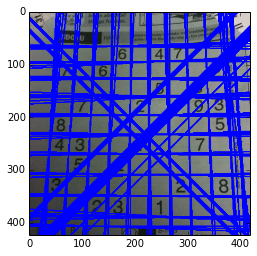

In [154]:
threshold = 0
lines = cv2.HoughLines(th2, rho=1, theta=np.pi/180, threshold=threshold)
print len(lines)
lines = lines[:100]
annotated = draw_hlines(img_org, lines)
plt.imshow(annotated)

9308 intersections
4654 Unique


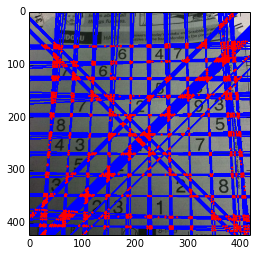

In [155]:
pointed = annotated.copy()

min_ang_diff = np.deg2rad(15) # 15 deg

intersections = {}
for i, line_a in enumerate(lines):
    for j, line_b in enumerate(lines):
        if i == j:
            continue
        ok, (x, y) = intersection(line_a, line_b, min_ang_diff)
        if not ok:
            continue
            
        intersections[(i, j)] = (x, y)

        cv2.circle(pointed, (x, y), 2, (255,0,0), thickness=-1)
print len(intersections), "intersections"
print len(set(tuple(sorted(k)) for k in intersections)), "Unique"
plt.imshow(pointed)

41


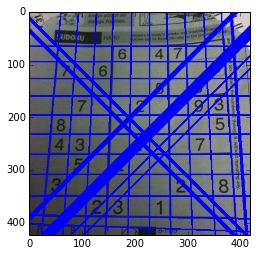

In [156]:
dedup = remove_duplicate_lines(lines[:], np.deg2rad(15), img.shape)
print len(dedup)
plt.imshow(draw_hlines(img_org, dedup))

In [147]:
def dist(p1, p2):
    return 1
#     try:
#         return cv2.norm(p1, p2)
#     except TypeError:
#         print "p1 %r" % ([p1])
#         print "p2 %r" % ([p2])
#         raise
#     return 0

def squarish(a, b, c, d):
    return 1

#     p4             d_i_lj            p1
#        x---------------------------x 
#        |             i             |
#        |                           |
#        |                           |
# d_l_ik | l                       j | d_j_ik
#        |                           |
#        |                           |
#        |             k             |
#        x---------------------------x
#     p3            d_k_lj             p2
#
# d_i_lj - a
# d_j_ik - b
# d_k_lj - c
# d_l_ik - d
#

for i, line_a in enumerate(dedup):
    for j, line_b in enumerate(dedup):
        p1 = intersections.get((i, j))
        if not p1:
            continue
        
        for k, line_d in enumerate(dedup):
            if k in (i,j):
                continue

            p2 = intersections.get((j, k))
            if not p2:
                continue

            try:
                d_j_ik = dist(p1, p2)
            except:
                print (i,j,k)
                raise
            
            for l, line_e in enumerate(dedup):
                if k == l:
                    continue
                
                p3 = intersections.get((k, l))
                p4 = intersections.get((l, i))
                
                if not p3 or not p4:
                    continue
                
                d_k_lj = dist(p2, p3)
                d_l_ik = dist(p3, p4)
                d_i_lj = dist(p4, p1)
                
                sq = squarish(a=d_i_lj, b=d_j_ik, c=d_k_lj, d=d_l_ik)


In [10]:
dist((30.28625, 391.87109), (390.28625, 391.87109))

360.0